MSRFuseNet - Preprocessing - DWT(3 Features) - APNEA - 39 

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, DWT features per epoch: 15
Valid epochs after masking: 45746


C:\Users\DST\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 1024, 1)     0           ['ppg_input[0][0]']              
                                                                                                  
 separable_conv1d (SeparableCon  (None, 1024, 32)    79          ['gaussian_noise[0][0]']         
 v1D)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 32)    128         ['separable_conv1d[0][0]']   

 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 32)      0           ['max_pooling1d_1[0][0]',        
                                                                  'average_pooling1d[0][0]']      
                                                                                                  
 add_1 (Add)                    (None, 256, 32)      0           ['batch_normalization_9[0][0]',  
                                                                  'tf.math.subtract[0][0]']       
          

 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 concatenate_1 (Concatenate)    (None, 8224)         0           ['flatten[0][0]',                
                                                                  'batch_normalization_14[0][0]'] 
                                                                                                  
 dense_6 (Dense)                (None, 64)           526400      ['concatenate_1[0][0]']          
                                                                                                  
 batch_nor

Epoch 36/100
2271/2271 [==============================] - 178s 79ms/step - loss: 0.1132 - accuracy: 0.7082 - val_loss: 0.1041 - val_accuracy: 0.7381 - lr: 1.0000e-04
Epoch 37/100
2271/2271 [==============================] - 181s 80ms/step - loss: 0.1122 - accuracy: 0.7081 - val_loss: 0.1027 - val_accuracy: 0.7360 - lr: 1.0000e-04
Epoch 38/100
2271/2271 [==============================] - 180s 79ms/step - loss: 0.1122 - accuracy: 0.7063 - val_loss: 0.1010 - val_accuracy: 0.7388 - lr: 1.0000e-04
Epoch 39/100
2271/2271 [==============================] - 179s 79ms/step - loss: 0.1118 - accuracy: 0.7093 - val_loss: 0.1057 - val_accuracy: 0.7389 - lr: 1.0000e-04
Epoch 40/100
2271/2271 [==============================] - 181s 80ms/step - loss: 0.1108 - accuracy: 0.7117 - val_loss: 0.1001 - val_accuracy: 0.7329 - lr: 1.0000e-04
Epoch 41/100
2271/2271 [==============================] - 183s 81ms/step - loss: 0.1101 - accuracy: 0.7124 - val_loss: 0.1036 - val_accuracy: 0.7453 - lr: 1.0000e-04
Epoc

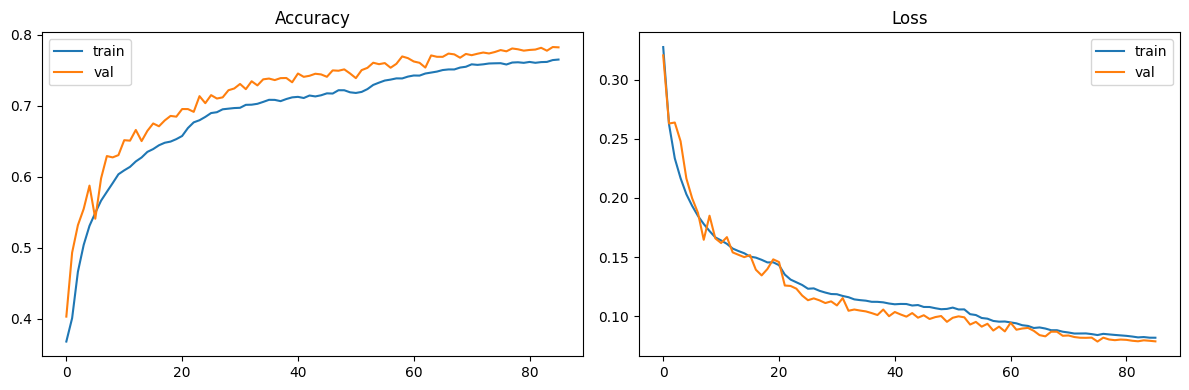

568/568 [==============================] - 10s 17ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.51      0.66      3633
           1       0.99      0.93      0.96      3632
           2       0.62      0.54      0.57      3633
           3       0.96      0.99      0.97      3633
           4       0.58      0.92      0.71      3632

    accuracy                           0.78     18163
   macro avg       0.81      0.78      0.77     18163
weighted avg       0.81      0.78      0.77     18163

[[1869    9  920    2  833]
 [  21 3385   37  115   74]
 [ 133   17 1949   23 1511]
 [   0   14    2 3589   28]
 [  35    6  242    5 3344]]

🧠 Cohen Kappa Score: 0.7229


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpxkcq91ob\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpxkcq91ob\assets



⏱️ Total training time: 261.74 minutes


In [1]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
import pywt  # Added for DWT

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_FS = 256  # Original sampling frequency
TARGET_FS = 34.3  # Target sampling frequency (from paper)
EPOCH_SAMPLES = 1024  # Samples per epoch at TARGET_FS
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_FS / EPOCH_SAMPLES)  # epochs in 1 hour
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR  # fixed length for each subject
DWT_LEVELS = 4  # Number of DWT decomposition levels
WAVELET = 'db4'  # Wavelet type for DWT

# --- Preprocessing functions ---

def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    nyq = 0.5 * fs
    wp = cutoff / nyq
    b, a = cheby2(order, rs, wp, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

def poly_detrend(signal, degree=10):
    x = np.arange(len(signal))
    coefs = Polynomial.fit(x, signal, degree).convert().coef
    trend = np.polyval(coefs[::-1], x)
    detrended = signal - trend
    return detrended

def min_max_norm(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val - min_val == 0:
        return signal * 0  # avoid div by zero if flat signal
    return (signal - min_val) / (max_val - min_val)

def extract_dwt_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    # Perform DWT decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # Flatten and compute statistical features (mean, std, energy) for each coefficient
    features = []
    for c in coeffs:
        features.extend([
            np.mean(c), np.std(c), np.sum(c**2)  # Mean, std, energy
        ])
    return np.array(features)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_FS, target_fs=TARGET_FS,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    # 1. Filter
    filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
    # 2. Detrend
    detrended = poly_detrend(filtered)
    # 3. Min-max normalization
    normalized = min_max_norm(detrended)
    # 4. Resample to target_fs
    up = int(target_fs * 1000)
    down = int(orig_fs * 1000)
    gcd = np.gcd(up, down)
    up //= gcd
    down //= gcd
    resampled = resample_poly(normalized, up, down)
    # 5. Epoching: slice into fixed length segments of epoch_samples
    total_samples = epoch_samples * total_epochs
    if len(resampled) > total_samples:
        resampled = resampled[:total_samples]
    elif len(resampled) < total_samples:
        pad_len = total_samples - len(resampled)
        resampled = np.pad(resampled, (0, pad_len), 'constant')
    # 6. Reshape to epochs
    epochs = resampled.reshape(total_epochs, epoch_samples)
    # Create mask to mark zero-padded epochs
    mask = np.array([0 if np.sum(e) == 0 else 1 for e in epochs])
    # 7. Extract DWT features for each epoch
    dwt_features = np.array([extract_dwt_features(epoch) for epoch in epochs])
    return epochs, dwt_features, mask

# --- Load raw data and preprocess once ---

folder_path = r"D:\abhishek_extracted\apnea"
mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]

X_epochs_list = []
X_dwt_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    mat = scipy.io.loadmat(file)
    raw_signal = mat['ppg_signals'].flatten()
    sleep_labels = mat['sleep_stages'].flatten()

    # Preprocess raw signal to epochs + DWT features + mask
    epochs, dwt_features, mask = preprocess_ppg_signal(raw_signal)

    # Adjust sleep labels to epochs length
    if len(sleep_labels) > epochs.shape[0]:
        sleep_labels = sleep_labels[:epochs.shape[0]]
    elif len(sleep_labels) < epochs.shape[0]:
        pad_len = epochs.shape[0] - len(sleep_labels)
        sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)

    X_epochs_list.append(epochs)
    X_dwt_list.append(dwt_features)
    y_epochs_list.append(sleep_labels)
    mask_list.append(mask)

X_all = np.vstack(X_epochs_list)  # shape: (total_epochs * subjects, epoch_samples)
X_dwt_all = np.vstack(X_dwt_list)  # shape: (total_epochs * subjects, dwt_feature_size)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, DWT features per epoch: {X_dwt_all.shape[1]}")

# Save preprocessed data
np.save("ppg_epochs.npy", X_all)
np.save("dwt_features.npy", X_dwt_all)
np.save("sleep_labels.npy", y_all)
np.save("epoch_mask.npy", mask_all)

# --- Filter out zero-padded epochs for training ---
valid_idx = y_all != -1  # remove epochs with padded labels
valid_idx = valid_idx & (mask_all == 1)  # remove zero-padded epochs

X_all = X_all[valid_idx]
X_dwt_all = X_dwt_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")

# --- Data Augmentation ---

def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

# Class-wise augmentation for minority classes
np.random.seed(42)
augmented_ppg = []
augmented_dwt = []
minority_classes = np.where(np.bincount(y_all) < np.median(np.bincount(y_all)))[0]

for ppg, dwt, label in zip(X_all, X_dwt_all, y_all):
    if label in minority_classes:
        if np.random.rand() < 0.5:
            ppg = jitter(ppg)
            dwt = jitter(dwt, sigma=0.005)  # Smaller jitter for DWT features
        if np.random.rand() < 0.5:
            ppg = magnitude_warp(ppg)
            # DWT features are statistical, so avoid warping
        if np.random.rand() < 0.5:
            ppg = scaling(ppg)
            dwt = scaling(dwt, sigma=0.05)  # Smaller scaling for DWT
    augmented_ppg.append(ppg)
    augmented_dwt.append(dwt)

X_aug = np.array(augmented_ppg)
X_dwt_aug = np.array(augmented_dwt)

# --- Standardization ---
scaler_ppg = StandardScaler()
X_scaled = scaler_ppg.fit_transform(X_aug)

scaler_dwt = StandardScaler()
X_dwt_scaled = scaler_dwt.fit_transform(X_dwt_aug)

# --- Handle Class Imbalance with SMOTE ---
# Concatenate PPG and DWT features for SMOTE
X_combined = np.concatenate([X_scaled, X_dwt_scaled], axis=1)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_combined, y_all)

# Split back into PPG and DWT
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_dwt = X_res[:, X_scaled.shape[1]:]

# --- Class weights ---
class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# --- Train-test split ---
X_train_ppg, X_test_ppg, X_train_dwt, X_test_dwt, y_train, y_test = train_test_split(
    X_res_ppg, X_res_dwt, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# Expand dims for CNN input
X_train_ppg = X_train_ppg[..., np.newaxis]
X_test_ppg = X_test_ppg[..., np.newaxis]

# One-hot encoding
num_classes = 5
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=[0.1, 0.5, 0.15, 1.0, 0.4]):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, dwt_shape):
    reg = l2(1e-4)
    
    # PPG Input Branch (CNN)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)

    # First CNN Block
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)

    # MSR-SE Block
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)

    # Second Conv Block + Residual
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)

    # Frequency Fusion Block
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)

    # Third Conv Block
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)

    # Attention
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation="relu", kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation="sigmoid", kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])

    # Residual Merge
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)

    # DWT Input Branch (MLP)
    dwt_input = Input(shape=dwt_shape, name='dwt_input')
    d = GaussianNoise(0.02)(dwt_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    dwt_out = d

    # Combine PPG and DWT branches
    combined = Concatenate()([ppg_out, dwt_out])

    # RVFL Dense Layers
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=[ppg_input, dwt_input], outputs=outputs)

# --- Compile & train ---
model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_dwt.shape[1],))
model.compile(optimizer=Adam(2e-4),  # Slightly increased learning rate
              loss=focal_loss(gamma=1.5, alpha=[0.1, 0.5, 0.15, 1.0, 0.4]),
              metrics=['accuracy'])

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_dwt.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

history = model.fit([X_train_ppg, X_train_dwt], y_train_cat, 
                    validation_data=([X_test_ppg, X_test_dwt], y_test_cat),
                    epochs=100, batch_size=32, class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

end_time = time.time()

# --- Plot training curves ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- Evaluation ---
y_pred = model.predict([X_test_ppg, X_test_dwt])
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

cm = confusion_matrix(y_true_cls, y_pred_cls)
print(cm)

kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")

# --- Save model ---
model.save("cnn_dwt_rvfl_light_model.keras")

# --- Export TFLite ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_dwt_rvfl_light_model.tflite", "wb") as f:
    f.write(tflite_model)

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [2]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")



✅ Overall Test Accuracy: 0.7783


In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.7748375735605633
Weighted F1 Score: 0.7748310399963886
Macro Precision: 0.8104402796862716
Macro Recall: 0.7783018275936078


In [4]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")



📈 Final Accuracy: Train = 0.7649, Val = 0.7821
📉 Final Loss: Train = 0.0818, Val = 0.0788


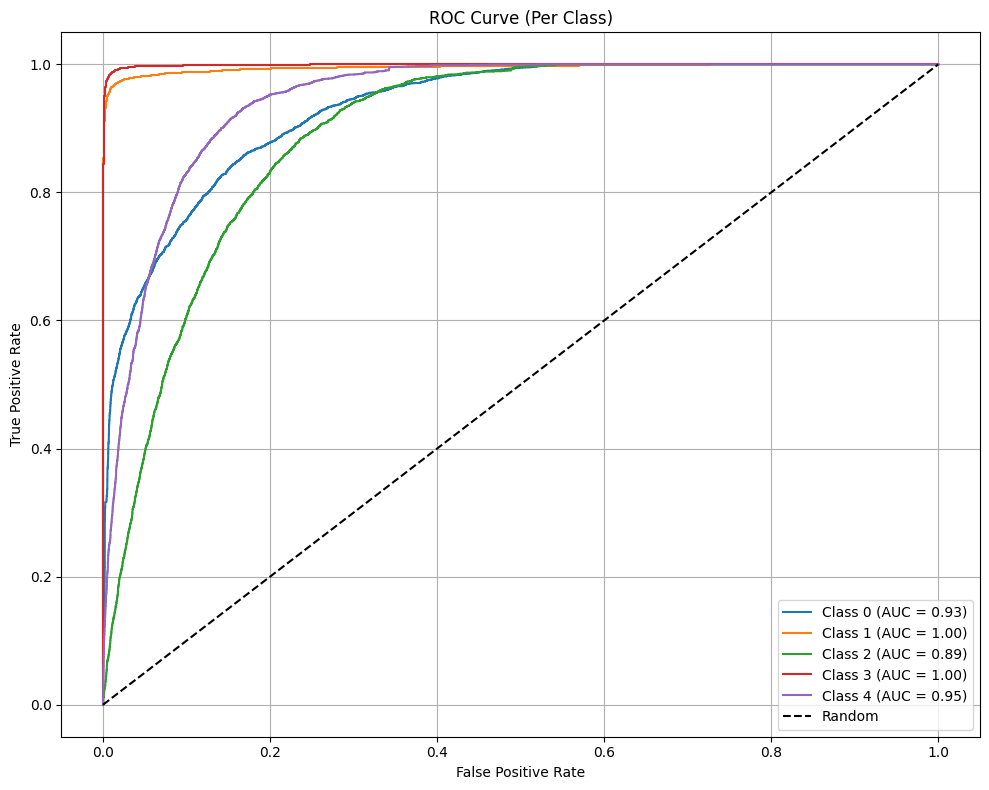

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 5
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


MSRFuseNet - Preprocessing - DWT(5 Features) - APNEA - 39 - (SKEWNESS AND KURTOSIS) - HJORTH PARAMETERS

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 20
Valid epochs after masking: 45746
X_aug shape: (55502, 1024), X_features_aug shape: (55502, 20), y_aug shape: (55502,)


C:\Users\DST\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 1024, 1)     0           ['ppg_input[0][0]']              
                                                                                                  
 separable_conv1d (SeparableCon  (None, 1024, 32)    79          ['gaussian_noise[0][0]']         
 v1D)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 32)    128         ['separable_conv1d[0][0]']   

 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 32)      0           ['max_pooling1d_1[0][0]',        
                                                                  'average_pooling1d[0][0]']      
                                                                                                  
 add_1 (Add)                    (None, 256, 32)      0           ['batch_normalization_9[0][0]',  
                                                                  'tf.math.subtract[0][0]']       
          

 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 concatenate_1 (Concatenate)    (None, 8224)         0           ['flatten[0][0]',                
                                                                  'batch_normalization_14[0][0]'] 
                                                                                                  
 dense_6 (Dense)                (None, 64)           526400      ['concatenate_1[0][0]']          
                                                                                                  
 batch_nor

Epoch 36/100
2271/2271 [==============================] - 183s 81ms/step - loss: 0.1633 - accuracy: 0.6476 - val_loss: 0.1576 - val_accuracy: 0.6777 - lr: 1.0000e-04
Epoch 37/100
2271/2271 [==============================] - 183s 81ms/step - loss: 0.1619 - accuracy: 0.6487 - val_loss: 0.1566 - val_accuracy: 0.6697 - lr: 1.0000e-04
Epoch 38/100
2271/2271 [==============================] - 183s 80ms/step - loss: 0.1597 - accuracy: 0.6536 - val_loss: 0.1543 - val_accuracy: 0.6817 - lr: 1.0000e-04
Epoch 39/100
2271/2271 [==============================] - 180s 79ms/step - loss: 0.1579 - accuracy: 0.6572 - val_loss: 0.1518 - val_accuracy: 0.6780 - lr: 1.0000e-04
Epoch 40/100
2271/2271 [==============================] - 180s 79ms/step - loss: 0.1579 - accuracy: 0.6562 - val_loss: 0.1518 - val_accuracy: 0.6833 - lr: 1.0000e-04
Epoch 41/100
2271/2271 [==============================] - 180s 79ms/step - loss: 0.1562 - accuracy: 0.6590 - val_loss: 0.1541 - val_accuracy: 0.6819 - lr: 1.0000e-04
Epoc

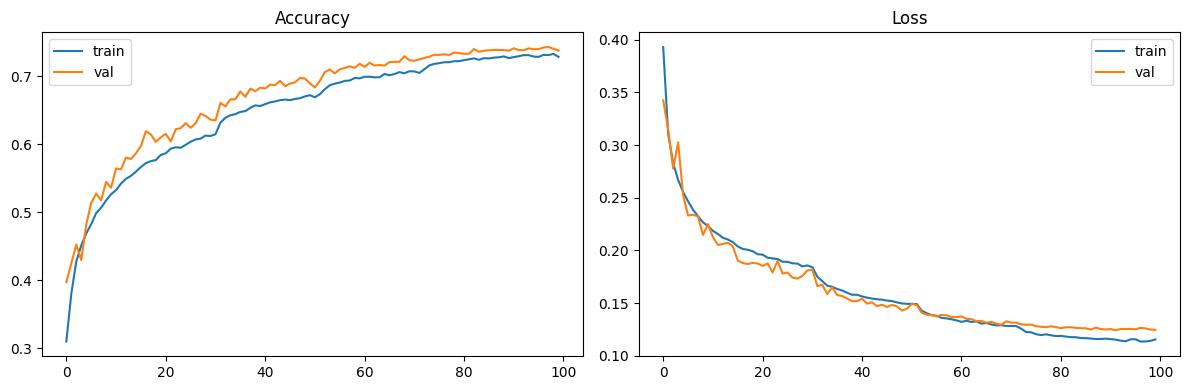

568/568 [==============================] - 10s 16ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.54      0.67      3633
           1       0.74      0.80      0.77      3632
           2       0.61      0.47      0.53      3633
           3       0.84      0.95      0.90      3633
           4       0.66      0.92      0.77      3632

    accuracy                           0.74     18163
   macro avg       0.75      0.74      0.73     18163
weighted avg       0.75      0.74      0.73     18163

[[1952  386  694   91  510]
 [  83 2914  229  192  214]
 [ 148  507 1708  306  964]
 [   6   53   54 3468   52]
 [  17   84  126   48 3357]]

🧠 Cohen Kappa Score: 0.6721


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp9nnvyc9r\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp9nnvyc9r\assets



⏱️ Total training time: 306.71 minutes


In [2]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
import pywt
from scipy.stats import skew, kurtosis

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_FS = 256
TARGET_FS = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_FS / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    activity = np.var(signal)
    diff = np.diff(signal)
    mobility = np.std(diff) / (np.std(signal) + 1e-10)
    diff2 = np.diff(diff)
    complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
    return np.array([activity, mobility, complexity])

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    nyq = 0.5 * fs
    wp = cutoff / nyq
    b, a = cheby2(order, rs, wp, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

def poly_detrend(signal, degree=10):
    x = np.arange(len(signal))
    coefs = Polynomial.fit(x, signal, degree).convert().coef
    trend = np.polyval(coefs[::-1], x)
    detrended = signal - trend
    return detrended

def min_max_norm(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val - min_val == 0:
        return signal * 0
    return (signal - min_val) / (max_val - min_val)

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    dwt_features = []
    for c in coeffs:
        dwt_features.extend([
            np.mean(c),
            np.std(c),
            np.sum(c**2)
        ])
    epoch_features = [
        skew(signal, bias=False),
        kurtosis(signal, bias=False)
    ]
    hjorth = hjorth_parameters(signal)
    return np.concatenate([dwt_features, epoch_features, hjorth])

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_FS, target_fs=TARGET_FS,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
    detrended = poly_detrend(filtered)
    normalized = min_max_norm(detrended)
    up = int(target_fs * 1000)
    down = int(orig_fs * 1000)
    gcd = np.gcd(up, down)
    up //= gcd
    down //= gcd
    resampled = resample_poly(normalized, up, down)
    total_samples = epoch_samples * total_epochs
    if len(resampled) > total_samples:
        resampled = resampled[:total_samples]
    elif len(resampled) < total_samples:
        pad_len = total_samples - len(resampled)
        resampled = np.pad(resampled, (0, pad_len), 'constant')
    epochs = resampled.reshape(total_epochs, epoch_samples)
    mask = np.array([0 if np.sum(e) == 0 else 1 for e in epochs])
    features = np.array([extract_features(epoch) for epoch in epochs])
    return epochs, features, mask

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\apnea"
mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    mat = scipy.io.loadmat(file)
    raw_signal = mat['ppg_signals'].flatten()
    sleep_labels = mat['sleep_stages'].flatten()
    epochs, features, mask = preprocess_ppg_signal(raw_signal)
    if len(sleep_labels) > epochs.shape[0]:
        sleep_labels = sleep_labels[:epochs.shape[0]]
    elif len(sleep_labels) < epochs.shape[0]:
        pad_len = epochs.shape[0] - len(sleep_labels)
        sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
    X_epochs_list.append(epochs)
    X_features_list.append(features)
    y_epochs_list.append(sleep_labels)
    mask_list.append(mask)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
np.save("ppg_epochs.npy", X_all)
np.save("features.npy", X_features_all)
np.save("sleep_labels.npy", y_all)
np.save("epoch_mask.npy", mask_all)

# --- Filter out zero-padded epochs ---
valid_idx = y_all != -1
valid_idx = valid_idx & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
minority_classes = np.where(np.bincount(y_all.astype(int)) < np.median(np.bincount(y_all.astype(int))))[0]

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in minority_classes:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# Verify sample consistency
print(f"X_aug shape: {X_aug.shape}, X_features_aug shape: {X_features_aug.shape}, y_aug shape: {y_aug.shape}")
if X_aug.shape[0] != y_aug.shape[0] or X_features_aug.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes after augmentation: X_aug={X_aug.shape[0]}, X_features_aug={X_features_aug.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Standardization ---
scaler_ppg = StandardScaler()
X_scaled = scaler_ppg.fit_transform(X_aug)
scaler_features = StandardScaler()
X_features_scaled = scaler_features.fit_transform(X_features_aug)

# --- Handle Class Imbalance with SMOTE ---
X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_combined, y_aug)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Class weights ---
class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# --- Train-test split ---
X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
    X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# Expand dims for CNN input
X_train_ppg = X_train_ppg[..., np.newaxis]
X_test_ppg = X_test_ppg[..., np.newaxis]

# One-hot encoding
num_classes = 5
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=[0.1, 0.5, 0.15, 1.0, 0.4]):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation="relu", kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation="sigmoid", kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
model.compile(optimizer=Adam(2e-4),
              loss=focal_loss(gamma=1.5, alpha=[0.1, 0.5, 0.15, 1.0, 0.4]),
              metrics=['accuracy'])

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                    validation_data=([X_test_ppg, X_test_features], y_test_cat),
                    epochs=100, batch_size=32, class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

end_time = time.time()

# --- Plot training curves ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- Evaluation ---
y_pred = model.predict([X_test_ppg, X_test_features])
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

cm = confusion_matrix(y_true_cls, y_pred_cls)
print(cm)

kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")

# --- Save model ---
model.save("cnn_features_rvfl_light_model.keras")

# --- Export TFLite ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_features_rvfl_light_model.tflite", "wb") as f:
    f.write(tflite_model)

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [3]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")



✅ Overall Test Accuracy: 0.7377


In [4]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.7267000927892349
Weighted F1 Score: 0.726695411213058
Macro Precision: 0.7469524684076673
Macro Recall: 0.7377223560097055


In [5]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.7284, Val = 0.7377
📉 Final Loss: Train = 0.1155, Val = 0.1246


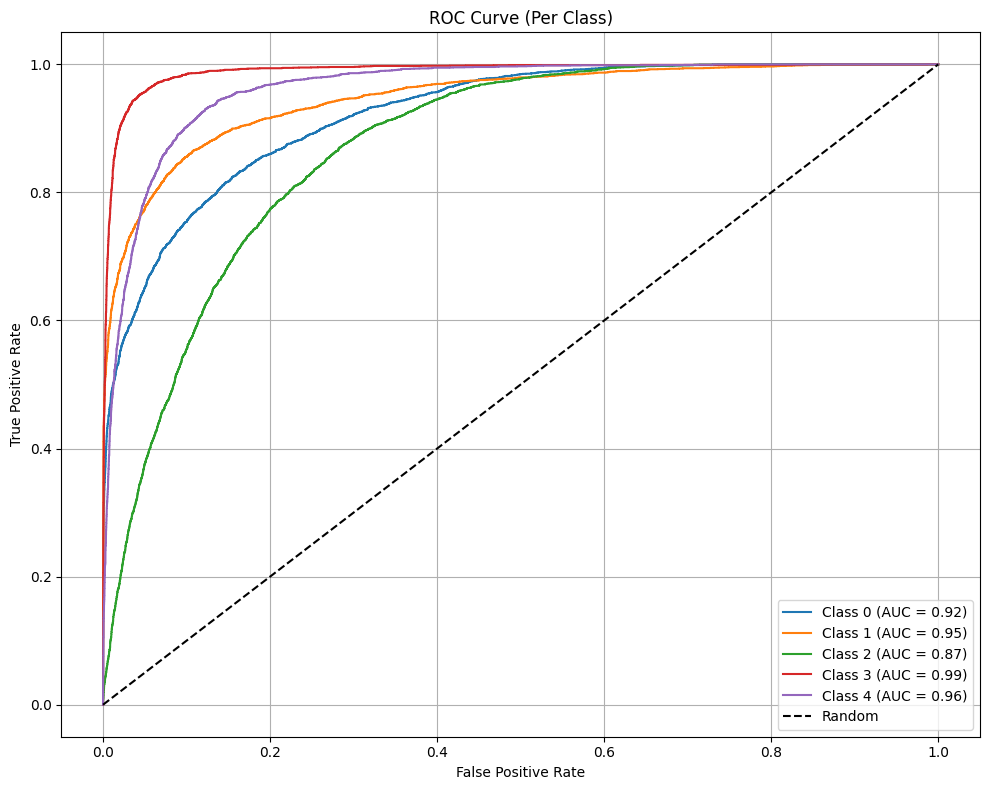

In [6]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 5
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
alpha=[0.1, 0.5, 0.15, 1.0, 0.4]

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 45746

Class Distribution Before Augmentation:
Class 0: 18163 samples (39.70%)
Class 1: 4348 samples (9.50%)
Class 2: 16370 samples (35.78%)
Class 3: 2114 samples (4.62%)
Class 4: 4751 samples (10.39%)

Class Distribution After Augmentation:
Class 0: 29093 samples (34.99%)
Class 1: 10847 samples (13.05%)
Class 2: 26103 samples (31.39%)
Class 3: 5229 samples (6.29%)
Class 4: 11873 samples (14.28%)


C:\Users\DST\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Class Distribution After SMOTE:
Class 0: 29093 samples (20.00%)
Class 1: 29093 samples (20.00%)
Class 2: 29093 samples (20.00%)
Class 3: 29093 samples (20.00%)
Class 4: 29093 samples (20.00%)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 1024, 1)     0           ['ppg_input[0][0]']              
                                                                                                  
 separable_conv1d (SeparableCon  (None, 1024, 32)    79          ['gaussian_noise[0][0]']         
 v1D)                                                                                             


                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 32)      0           ['max_pooling1d_1[0][0]',        
                                                                  'average_pooling1d[0][0]']      
                                                                                                  
 add_1 (Ad

 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 concatenate_1 (Concatenate)    (None, 8224)         0           ['flatten[0][0]',                
                                                                  'batch_normalization_14[0][0]'] 
                                                                                                  
 dense_6 (

3637/3637 [==============================] - 284s 78ms/step - loss: 0.1975 - accuracy: 0.6082 - val_loss: 0.1795 - val_accuracy: 0.6184 - lr: 2.0000e-04
Epoch 35/100
3637/3637 [==============================] - 284s 78ms/step - loss: 0.1960 - accuracy: 0.6090 - val_loss: 0.1773 - val_accuracy: 0.6319 - lr: 2.0000e-04
Epoch 36/100
3637/3637 [==============================] - 286s 79ms/step - loss: 0.1866 - accuracy: 0.6258 - val_loss: 0.1655 - val_accuracy: 0.6480 - lr: 1.0000e-04
Epoch 37/100
3637/3637 [==============================] - 289s 79ms/step - loss: 0.1795 - accuracy: 0.6355 - val_loss: 0.1612 - val_accuracy: 0.6515 - lr: 1.0000e-04
Epoch 38/100
3637/3637 [==============================] - 282s 77ms/step - loss: 0.1763 - accuracy: 0.6397 - val_loss: 0.1610 - val_accuracy: 0.6526 - lr: 1.0000e-04
Epoch 39/100
3637/3637 [==============================] - 281s 77ms/step - loss: 0.1733 - accuracy: 0.6435 - val_loss: 0.1597 - val_accuracy: 0.6511 - lr: 1.0000e-04
Epoch 40/100
3637

3637/3637 [==============================] - 309s 85ms/step - loss: 0.1238 - accuracy: 0.7197 - val_loss: 0.1191 - val_accuracy: 0.7201 - lr: 1.2500e-05
Epoch 84/100
3637/3637 [==============================] - 304s 83ms/step - loss: 0.1236 - accuracy: 0.7214 - val_loss: 0.1192 - val_accuracy: 0.7197 - lr: 1.2500e-05
Epoch 85/100
3637/3637 [==============================] - 306s 84ms/step - loss: 0.1236 - accuracy: 0.7210 - val_loss: 0.1191 - val_accuracy: 0.7198 - lr: 1.2500e-05
Epoch 86/100
3637/3637 [==============================] - 304s 84ms/step - loss: 0.1226 - accuracy: 0.7220 - val_loss: 0.1188 - val_accuracy: 0.7218 - lr: 1.2500e-05
Epoch 87/100
3637/3637 [==============================] - 304s 83ms/step - loss: 0.1219 - accuracy: 0.7230 - val_loss: 0.1176 - val_accuracy: 0.7231 - lr: 1.2500e-05
Epoch 88/100
3637/3637 [==============================] - 304s 83ms/step - loss: 0.1221 - accuracy: 0.7244 - val_loss: 0.1176 - val_accuracy: 0.7228 - lr: 1.2500e-05
Epoch 89/100
3637

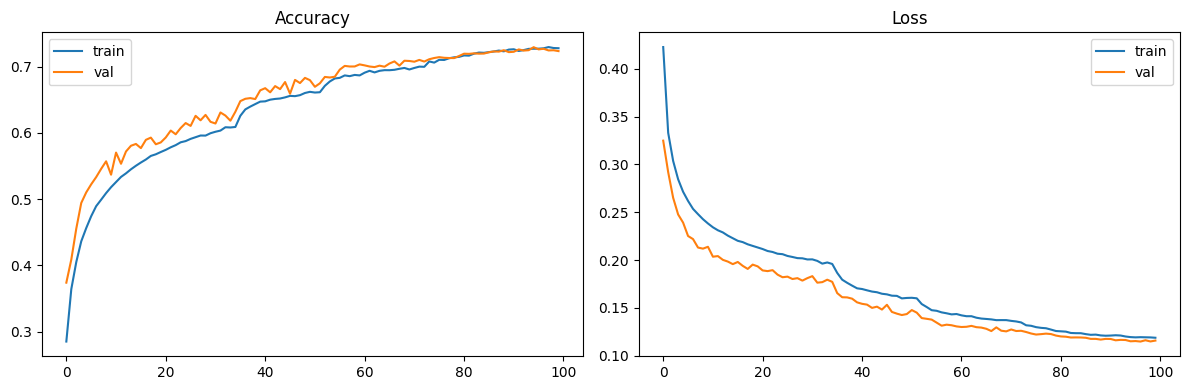

910/910 [==============================] - 19s 20ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.56      0.68      5819
           1       0.65      0.89      0.75      5818
           2       0.69      0.39      0.50      5819
           3       0.78      0.99      0.87      5819
           4       0.68      0.80      0.73      5818

    accuracy                           0.72     29093
   macro avg       0.74      0.72      0.71     29093
weighted avg       0.74      0.72      0.71     29093

Confusion Matrix:
[[3250  993  815  222  539]
 [  58 5155   71  153  381]
 [ 356 1192 2258  769 1244]
 [   1   25    9 5743   41]
 [  20  611  107  436 4644]]

🧠 Cohen Kappa Score: 0.6544


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpj1l0jgek\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpj1l0jgek\assets



⏱️ Total training time: 495.34 minutes


In [1]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
import pywt
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_FS = 256
TARGET_FS = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_FS / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    activity = np.var(signal)
    diff = np.diff(signal)
    mobility = np.std(diff) / (np.std(signal) + 1e-10)
    diff2 = np.diff(diff)
    complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
    return np.array([activity, mobility, complexity])

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    nyq = 0.5 * fs
    wp = cutoff / nyq
    b, a = cheby2(order, rs, wp, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

def poly_detrend(signal, degree=10):
    x = np.arange(len(signal))
    coefs = Polynomial.fit(x, signal, degree).convert().coef
    trend = np.polyval(coefs[::-1], x)
    detrended = signal - trend
    return detrended

def min_max_norm(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val - min_val == 0:
        return signal * 0
    return (signal - min_val) / (max_val - min_val)

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    dwt_features = []
    for c in coeffs:
        dwt_features.extend([
            np.mean(c),
            np.std(c),
            np.sum(c**2),
            skew(c, bias=False),
            kurtosis(c, bias=False)
        ])
    hjorth = hjorth_parameters(signal)
    return np.concatenate([dwt_features, hjorth])

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_FS, target_fs=TARGET_FS,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
    detrended = poly_detrend(filtered)
    normalized = min_max_norm(detrended)
    up = int(target_fs * 1000)
    down = int(orig_fs * 1000)
    gcd = np.gcd(up, down)
    up //= gcd
    down //= gcd
    resampled = resample_poly(normalized, up, down)
    total_samples = epoch_samples * total_epochs
    if len(resampled) > total_samples:
        resampled = resampled[:total_samples]
    elif len(resampled) < total_samples:
        pad_len = total_samples - len(resampled)
        resampled = np.pad(resampled, (0, pad_len), 'constant')
    epochs = resampled.reshape(total_epochs, epoch_samples)
    mask = np.array([0 if np.sum(e) == 0 else 1 for e in epochs])
    features = np.array([extract_features(epoch) for epoch in epochs])
    return epochs, features, mask

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\apnea"
mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    mat = scipy.io.loadmat(file)
    raw_signal = mat['ppg_signals'].flatten()
    sleep_labels = mat['sleep_stages'].flatten()
    epochs, features, mask = preprocess_ppg_signal(raw_signal)
    if len(sleep_labels) > epochs.shape[0]:
        sleep_labels = sleep_labels[:epochs.shape[0]]
    elif len(sleep_labels) < epochs.shape[0]:
        pad_len = epochs.shape[0] - len(sleep_labels)
        sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
    X_epochs_list.append(epochs)
    X_features_list.append(features)
    y_epochs_list.append(sleep_labels)
    mask_list.append(mask)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
np.save("ppg_epochs.npy", X_all)
np.save("features.npy", X_features_all)
np.save("sleep_labels.npy", y_all)
np.save("epoch_mask.npy", mask_all)

# --- Filter out zero-padded epochs ---
valid_idx = y_all != -1
valid_idx = valid_idx & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 2]

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            aug_feat = feat
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
scaler_ppg = StandardScaler()
X_scaled = scaler_ppg.fit_transform(X_aug)
scaler_features = StandardScaler()
X_features_scaled = scaler_features.fit_transform(X_features_aug)

# --- Handle Class Imbalance with SMOTE ---
X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_combined, y_aug)

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Class weights ---
class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# --- Train-test split ---
X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
    X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# Expand dims for CNN input
X_train_ppg = X_train_ppg[..., np.newaxis]
X_test_ppg = X_test_ppg[..., np.newaxis]

# One-hot encoding
num_classes = 5
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=[0.1, 0.5, 0.15, 1.0, 0.4]):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation="relu", kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation="sigmoid", kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
model.compile(optimizer=Adam(2e-4),
              loss=focal_loss(gamma=1.5, alpha=[0.1, 0.5, 0.15, 1.0, 0.4]),
              metrics=['accuracy'])

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                    validation_data=([X_test_ppg, X_test_features], y_test_cat),
                    epochs=100, batch_size=32, class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

end_time = time.time()

# --- Plot training curves ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- Evaluation ---
y_pred = model.predict([X_test_ppg, X_test_features])
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

cm = confusion_matrix(y_true_cls, y_pred_cls)
print("Confusion Matrix:")
print(cm)

kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")

# --- Save model ---
model.save("cnn_features_rvfl_light_model.keras")

# --- Export TFLite ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_features_rvfl_light_model.tflite", "wb") as f:
    f.write(tflite_model)

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [2]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")



✅ Overall Test Accuracy: 0.7235


In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))

Macro F1 Score: 0.7071992458979747
Weighted F1 Score: 0.7071969679690059
Macro Precision: 0.7366404934620041
Macro Recall: 0.723549897087403


In [4]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.7279, Val = 0.7235
📉 Final Loss: Train = 0.1188, Val = 0.1159


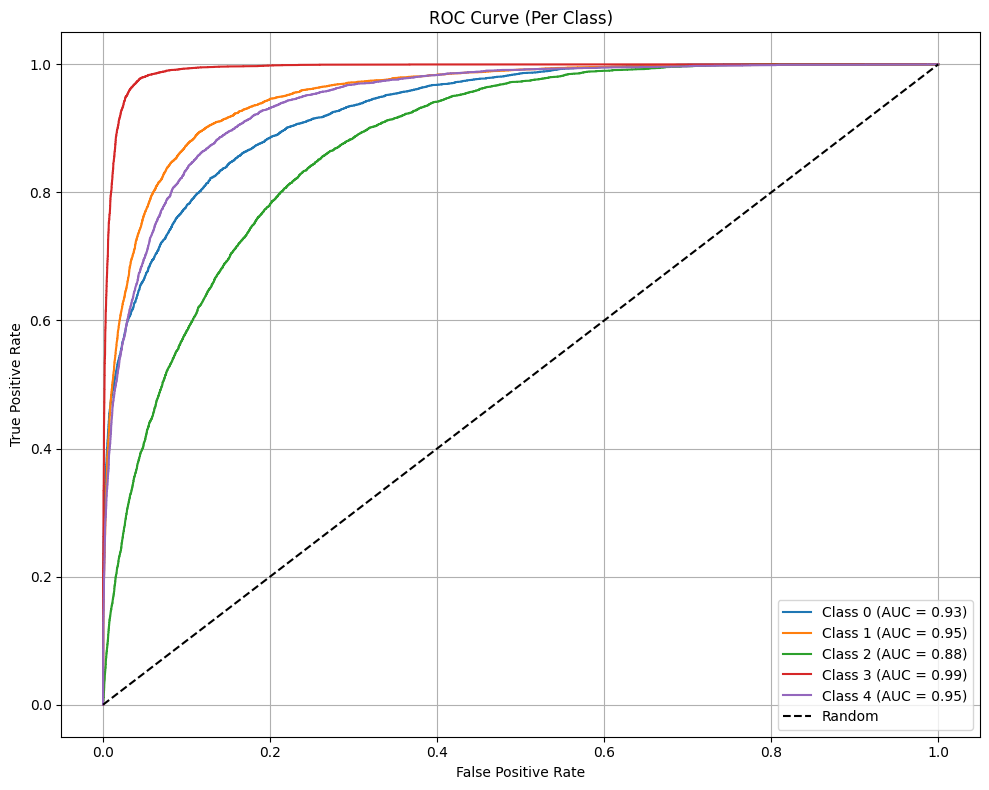

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 5
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 45746

Class Distribution Before Augmentation:
Class 0: 18163 samples (39.70%)
Class 1: 20718 samples (45.29%)
Class 2: 2114 samples (4.62%)
Class 3: 4751 samples (10.39%)

Class Distribution After Augmentation:
Class 0: 29104 samples (36.62%)
Class 1: 33147 samples (41.70%)
Class 2: 5307 samples (6.68%)
Class 3: 11923 samples (15.00%)

Class Distribution After SMOTE:
Class 0: 33147 samples (25.00%)
Class 1: 33147 samples (25.00%)
Class 2: 33147 samples (25.00%)
Class 3: 33147 samples (25.00%)

Fixed Focal Loss Alpha: [0.2, 0.2, 0.4, 0.3]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0         

                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 256, 32)     0           ['spatial_dropout1d_1[0][0]']    
                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalizati

 dropout (Dropout)              (None, 64)           0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalizat

3315/3315 [==============================] - 273s 82ms/step - loss: 0.0671 - accuracy: 0.8146 - val_loss: 0.0697 - val_accuracy: 0.8038 - lr: 6.2500e-06
Epoch 81/100
3315/3315 [==============================] - 276s 83ms/step - loss: 0.0673 - accuracy: 0.8155 - val_loss: 0.0700 - val_accuracy: 0.8033 - lr: 6.2500e-06
Epoch 82/100
3315/3315 [==============================] - 277s 83ms/step - loss: 0.0667 - accuracy: 0.8161 - val_loss: 0.0693 - val_accuracy: 0.8056 - lr: 6.2500e-06
Epoch 83/100
3315/3315 [==============================] - 277s 84ms/step - loss: 0.0662 - accuracy: 0.8171 - val_loss: 0.0700 - val_accuracy: 0.8032 - lr: 6.2500e-06
Epoch 84/100
3315/3315 [==============================] - 275s 83ms/step - loss: 0.0665 - accuracy: 0.8157 - val_loss: 0.0693 - val_accuracy: 0.8054 - lr: 6.2500e-06
Epoch 85/100
3315/3315 [==============================] - 273s 82ms/step - loss: 0.0663 - accuracy: 0.8167 - val_loss: 0.0693 - val_accuracy: 0.8055 - lr: 6.2500e-06
Epoch 86/100
3315

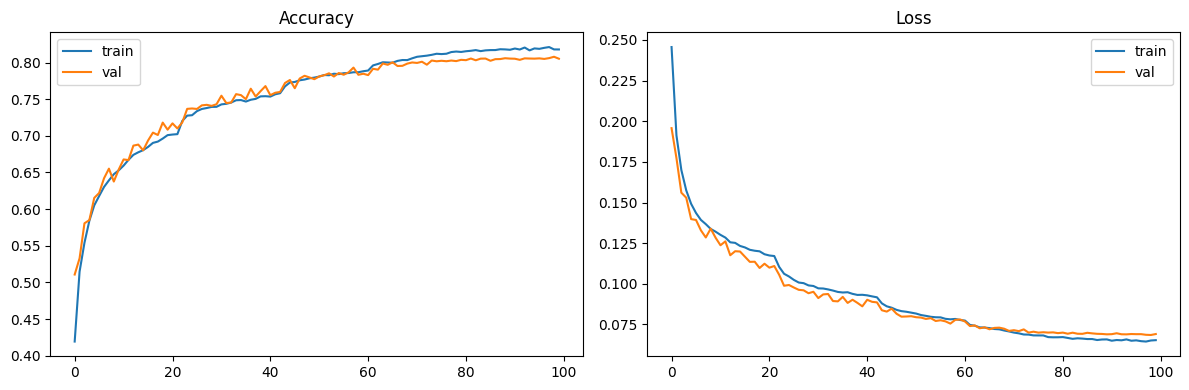

829/829 [==============================] - 18s 21ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      6630
           1       0.73      0.63      0.68      6629
           2       0.87      0.97      0.92      6630
           3       0.77      0.89      0.83      6629

    accuracy                           0.81     26518
   macro avg       0.80      0.81      0.80     26518
weighted avg       0.80      0.81      0.80     26518

Confusion Matrix:
[[4830 1195  119  486]
 [ 800 4176  488 1165]
 [  10   58 6458  104]
 [  78  291  369 5891]]

🧠 Cohen Kappa Score: 0.7404


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpk5i3s705\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpk5i3s705\assets



⏱️ Total training time: 453.40 minutes


In [7]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_SF = 256
TARGET_SF = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_SF / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 4

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def map_to_4_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> Light Sleep
        2: 1,  # N2 -> Light Sleep
        3: 2,  # N3 -> Deep Sleep
        4: 3   # REM
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_SF, target_fs=TARGET_SF,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\apnea"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        sleep_labels = map_to_4_classes(sleep_labels)
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels_4class.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 1]  # Wake, Light Sleep

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# --- Class weights ---
try:
    class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
except Exception as e:
    print(f"Error computing class weights: {e}")
    exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Fixed alpha for focal loss ---
alpha_fixed = np.array([0.2, 0.2, 0.4, 0.3])
print(f"\nFixed Focal Loss Alpha: {alpha_fixed.tolist()}")

# --- Focal loss function ---
def focal_loss(gamma=1.5, alpha=alpha_fixed):
    alpha = tf.constant(alpha, dtype=tf.float32)
    
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5, alpha=alpha_fixed),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_4class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                        validation_data=([X_test_ppg, X_test_features], y_test_cat),
                        epochs=100, batch_size=32, class_weight=class_weight_dict,
                        callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_4class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_4class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [8]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.8053


In [9]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.8005937907386853
Weighted F1 Score: 0.80059754285027
Macro Precision: 0.8034876048677391
Macro Recall: 0.805298590884652


In [10]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.8180, Val = 0.8053
📉 Final Loss: Train = 0.0654, Val = 0.0691


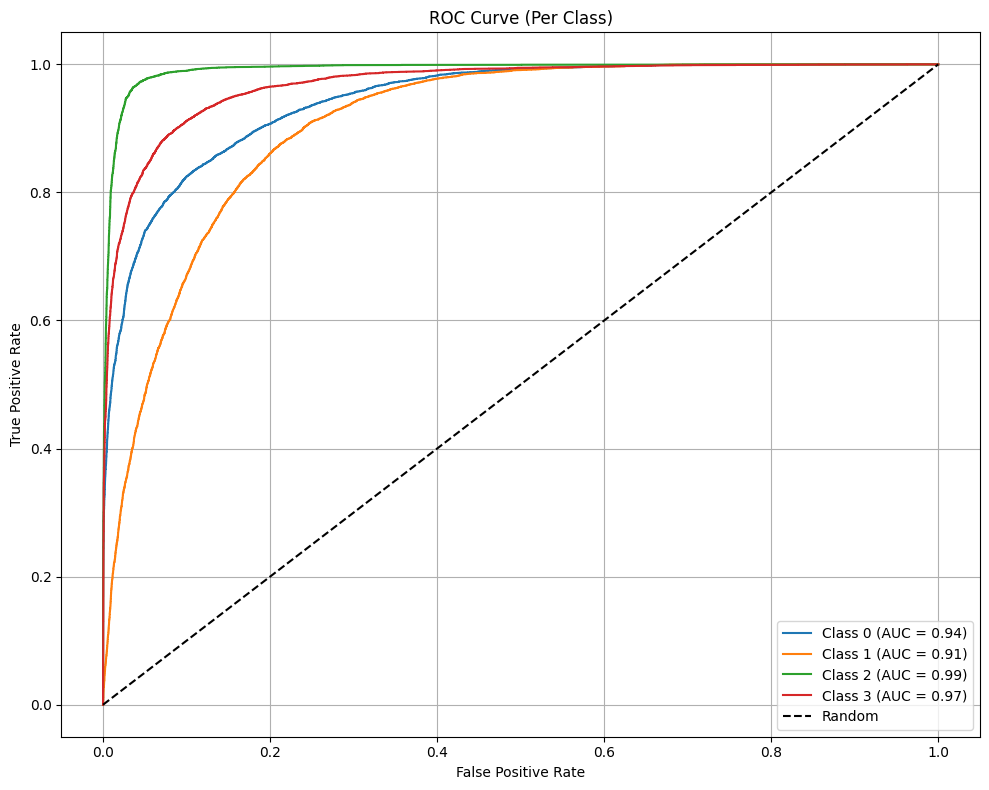

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 4
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



MSRFuseNet - Preprocessing - DWT(5 Features) - APNEA - 39 - (SKEWNESS AND KURTOSIS) - HJORTH PARAMETERS - 4 CLASS (REDUCED CLASS GROUPINGS)

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, DWT features per epoch: 25
Valid epochs after masking: 45746


C:\Users\DST\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 1024, 1)     0           ['ppg_input[0][0]']              
                                                                                                  
 separable_conv1d (SeparableCon  (None, 1024, 32)    79          ['gaussian_noise[0][0]']         
 v1D)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 32)    128         ['separable_conv1d[0][0]']   

 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 32)      0           ['max_pooling1d_1[0][0]',        
                                                                  'average_pooling1d[0][0]']      
                                                                                                  
 add_1 (Add)                    (None, 256, 32)      0           ['batch_normalization_9[0][0]',  
                                                                  'tf.math.subtract[0][0]']       
          

 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 concatenate_1 (Concatenate)    (None, 8224)         0           ['flatten[0][0]',                
                                                                  'batch_normalization_14[0][0]'] 
                                                                                                  
 dense_6 (Dense)                (None, 64)           526400      ['concatenate_1[0][0]']          
                                                                                                  
 batch_nor

Epoch 36/100
2072/2072 [==============================] - 169s 81ms/step - loss: 0.0596 - accuracy: 0.8219 - val_loss: 0.0591 - val_accuracy: 0.8358 - lr: 2.5000e-05
Epoch 37/100
2072/2072 [==============================] - 163s 79ms/step - loss: 0.0589 - accuracy: 0.8238 - val_loss: 0.0587 - val_accuracy: 0.8369 - lr: 2.5000e-05
Epoch 38/100
2072/2072 [==============================] - 165s 80ms/step - loss: 0.0584 - accuracy: 0.8246 - val_loss: 0.0581 - val_accuracy: 0.8395 - lr: 2.5000e-05
Epoch 39/100
2072/2072 [==============================] - 164s 79ms/step - loss: 0.0582 - accuracy: 0.8237 - val_loss: 0.0580 - val_accuracy: 0.8385 - lr: 2.5000e-05
Epoch 40/100
2072/2072 [==============================] - 164s 79ms/step - loss: 0.0575 - accuracy: 0.8270 - val_loss: 0.0555 - val_accuracy: 0.8427 - lr: 2.5000e-05
Epoch 41/100
2072/2072 [==============================] - 168s 81ms/step - loss: 0.0574 - accuracy: 0.8266 - val_loss: 0.0551 - val_accuracy: 0.8453 - lr: 2.5000e-05
Epoc

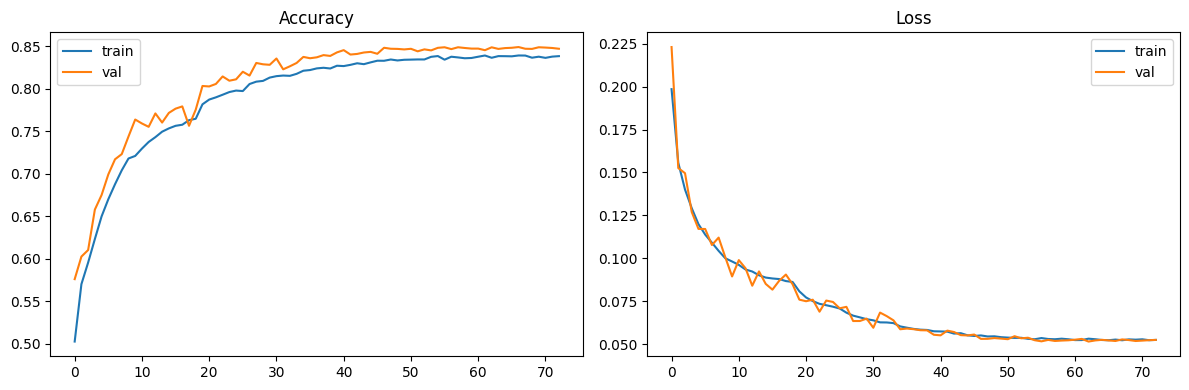

518/518 [==============================] - 9s 15ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      4144
           1       0.69      0.82      0.75      4143
           2       0.97      0.96      0.96      4144
           3       0.98      0.90      0.94      4144

    accuracy                           0.85     16575
   macro avg       0.86      0.85      0.85     16575
weighted avg       0.86      0.85      0.85     16575

[[2937 1195    5    7]
 [ 714 3409    8   12]
 [   4   91 3986   63]
 [  19  265  126 3734]]

🧠 Cohen Kappa Score: 0.7982


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpos7c9d82\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpos7c9d82\assets



⏱️ Total training time: 205.18 minutes


In [1]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis  # Added for skewness and kurtosis
import pywt  # Added for DWT

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_FS = 256  # Original sampling frequency
TARGET_FS = 34.3  # Target sampling frequency (from paper)
EPOCH_SAMPLES = 1024  # Samples per epoch at TARGET_FS
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_FS / EPOCH_SAMPLES)  # epochs in 1 hour
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR  # fixed length for each subject
DWT_LEVELS = 4  # Number of DWT decomposition levels
WAVELET = 'db4'  # Wavelet type for DWT

# --- Preprocessing functions ---

def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    nyq = 0.5 * fs
    wp = cutoff / nyq
    b, a = cheby2(order, rs, wp, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

def poly_detrend(signal, degree=10):
    x = np.arange(len(signal))
    coefs = Polynomial.fit(x, signal, degree).convert().coef
    trend = np.polyval(coefs[::-1], x)
    detrended = signal - trend
    return detrended

def min_max_norm(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val - min_val == 0:
        return signal * 0  # avoid div by zero if flat signal
    return (signal - min_val) / (max_val - min_val)

def extract_dwt_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    # Perform DWT decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # Compute statistical features (mean, std, energy, skewness, kurtosis) for each coefficient
    features = []
    for c in coeffs:
        features.extend([
            np.mean(c),           # Mean
            np.std(c),            # Standard deviation
            np.sum(c**2),         # Energy
            skew(c, bias=False),  # Skewness
            kurtosis(c, bias=False)  # Kurtosis
        ])
    return np.array(features)

def map_to_4_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> Light Sleep
        2: 1,  # N2 -> Light Sleep
        3: 2,  # N3 -> Deep Sleep
        4: 3   # REM
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_FS, target_fs=TARGET_FS,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    # 1. Filter
    filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
    # 2. Detrend
    detrended = poly_detrend(filtered)
    # 3. Min-max normalization
    normalized = min_max_norm(detrended)
    # 4. Resample to target_fs
    up = int(target_fs * 1000)
    down = int(orig_fs * 1000)
    gcd = np.gcd(up, down)
    up //= gcd
    down //= gcd
    resampled = resample_poly(normalized, up, down)
    # 5. Epoching: slice into fixed length segments of epoch_samples
    total_samples = epoch_samples * total_epochs
    if len(resampled) > total_samples:
        resampled = resampled[:total_samples]
    elif len(resampled) < total_samples:
        pad_len = total_samples - len(resampled)
        resampled = np.pad(resampled, (0, pad_len), 'constant')
    # 6. Reshape to epochs
    epochs = resampled.reshape(total_epochs, epoch_samples)
    # Create mask to mark zero-padded epochs
    mask = np.array([0 if np.sum(e) == 0 else 1 for e in epochs])
    # 7. Extract DWT features for each epoch
    dwt_features = np.array([extract_dwt_features(epoch) for epoch in epochs])
    return epochs, dwt_features, mask

# --- Load raw data and preprocess once ---

folder_path = r"D:\abhishek_extracted\apnea"
mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]

X_epochs_list = []
X_dwt_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    mat = scipy.io.loadmat(file)
    raw_signal = mat['ppg_signals'].flatten()
    sleep_labels = mat['sleep_stages'].flatten()

    # Preprocess raw signal to epochs + DWT features + mask
    epochs, dwt_features, mask = preprocess_ppg_signal(raw_signal)

    # Map sleep labels to 4 classes
    sleep_labels = map_to_4_classes(sleep_labels)

    # Adjust sleep labels to epochs length
    if len(sleep_labels) > epochs.shape[0]:
        sleep_labels = sleep_labels[:epochs.shape[0]]
    elif len(sleep_labels) < epochs.shape[0]:
        pad_len = epochs.shape[0] - len(sleep_labels)
        sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)

    X_epochs_list.append(epochs)
    X_dwt_list.append(dwt_features)
    y_epochs_list.append(sleep_labels)
    mask_list.append(mask)

X_all = np.vstack(X_epochs_list)  # shape: (total_epochs * subjects, epoch_samples)
X_dwt_all = np.vstack(X_dwt_list)  # shape: (total_epochs * subjects, dwt_feature_size)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, DWT features per epoch: {X_dwt_all.shape[1]}")

# Save preprocessed data
np.save("ppg_epochs.npy", X_all)
np.save("dwt_features.npy", X_dwt_all)
np.save("sleep_labels_4class.npy", y_all)
np.save("epoch_mask.npy", mask_all)

# --- Filter out zero-padded epochs for training ---
valid_idx = y_all != -1  # remove epochs with padded labels
valid_idx = valid_idx & (mask_all == 1)  # remove zero-padded epochs

X_all = X_all[valid_idx]
X_dwt_all = X_dwt_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")

# --- Data Augmentation ---

def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

# Class-wise augmentation for minority classes
np.random.seed(42)
augmented_ppg = []
augmented_dwt = []
minority_classes = np.where(np.bincount(y_all.astype(int), minlength=4) < np.median(np.bincount(y_all.astype(int), minlength=4)))[0]

for ppg, dwt, label in zip(X_all, X_dwt_all, y_all):
    if label in minority_classes:
        if np.random.rand() < 0.5:
            ppg = jitter(ppg)
            dwt = jitter(dwt, sigma=0.005)  # Smaller jitter for DWT features
        if np.random.rand() < 0.5:
            ppg = magnitude_warp(ppg)
            # DWT features are statistical, so avoid warping
        if np.random.rand() < 0.5:
            ppg = scaling(ppg)
            dwt = scaling(dwt, sigma=0.05)  # Smaller scaling for DWT
    augmented_ppg.append(ppg)
    augmented_dwt.append(dwt)

X_aug = np.array(augmented_ppg)
X_dwt_aug = np.array(augmented_dwt)

# --- Standardization ---
scaler_ppg = StandardScaler()
X_scaled = scaler_ppg.fit_transform(X_aug)

scaler_dwt = StandardScaler()
X_dwt_scaled = scaler_dwt.fit_transform(X_dwt_aug)

# --- Handle Class Imbalance with SMOTE ---
# Concatenate PPG and DWT features for SMOTE
X_combined = np.concatenate([X_scaled, X_dwt_scaled], axis=1)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_combined, y_all)

# Split back into PPG and DWT
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_dwt = X_res[:, X_scaled.shape[1]:]

# --- Class weights ---
class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# --- Train-test split ---
X_train_ppg, X_test_ppg, X_train_dwt, X_test_dwt, y_train, y_test = train_test_split(
    X_res_ppg, X_res_dwt, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# Expand dims for CNN input
X_train_ppg = X_train_ppg[..., np.newaxis]
X_test_ppg = X_test_ppg[..., np.newaxis]

# One-hot encoding
num_classes = 4
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=[0.2, 0.2, 0.4, 0.3]):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, dwt_shape):
    reg = l2(1e-4)
    
    # PPG Input Branch (CNN)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)

    # First CNN Block
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)

    # MSR-SE Block
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)

    # Second Conv Block + Residual
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)

    # Frequency Fusion Block
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)

    # Third Conv Block
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)

    # Attention
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation="relu", kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation="sigmoid", kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])

    # Residual Merge
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)

    # DWT Input Branch (MLP)
    dwt_input = Input(shape=dwt_shape, name='dwt_input')
    d = GaussianNoise(0.02)(dwt_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    dwt_out = d

    # Combine PPG and DWT branches
    combined = Concatenate()([ppg_out, dwt_out])

    # RVFL Dense Layers
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=[ppg_input, dwt_input], outputs=outputs)

# --- Compile & train ---
model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_dwt.shape[1],))
model.compile(optimizer=Adam(2e-4),  # Slightly increased learning rate
              loss=focal_loss(gamma=1.5, alpha=[0.2, 0.2, 0.4, 0.3]),
              metrics=['accuracy'])

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_dwt_4class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

history = model.fit([X_train_ppg, X_train_dwt], y_train_cat, 
                    validation_data=([X_test_ppg, X_test_dwt], y_test_cat),
                    epochs=100, batch_size=32, class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

end_time = time.time()

# --- Plot training curves ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- Evaluation ---
y_pred = model.predict([X_test_ppg, X_test_dwt])
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

cm = confusion_matrix(y_true_cls, y_pred_cls)
print(cm)

kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")

# --- Save model ---
model.save("cnn_dwt_rvfl_light_model_4class.keras")

# --- Export TFLite ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_dwt_rvfl_light_model_4class.tflite", "wb") as f:
    f.write(tflite_model)

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [2]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.8486


In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.8506501448321347
Weighted F1 Score: 0.8506562785451577
Macro Precision: 0.8578785363507294
Macro Recall: 0.8486258948899246


In [4]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.8382, Val = 0.8469
📉 Final Loss: Train = 0.0524, Val = 0.0524


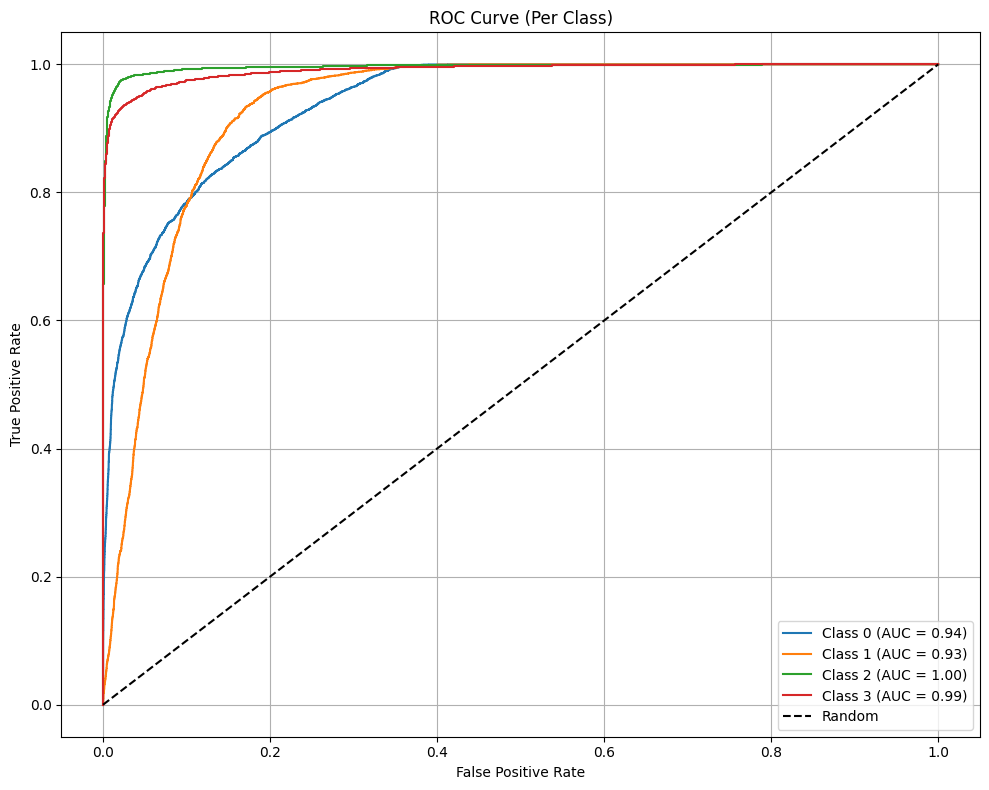

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 4
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, DWT features per epoch: 25
Valid epochs after masking: 45746

Class Distribution Before Augmentation:
Class 0: 18163 samples (39.70%)
Class 1: 20718 samples (45.29%)
Class 2: 2114 samples (4.62%)
Class 3: 4751 samples (10.39%)

Class Distribution After Augmentation:
Class 0: 18163 samples (32.43%)
Class 1: 20718 samples (37.00%)
Class 2: 5288 samples (9.44%)
Class 3: 11831 samples (21.13%)

Class Distribution After SMOTE:
Class 0: 20718 samples (25.00%)
Class 1: 20718 samples (25.00%)
Class 2: 20718 samples (25.00%)
Class 3: 20718 samples (25.00%)

Dynamic Focal Loss Alpha: [1.0, 1.0, 1.0, 1.0]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0   

                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 256, 32)     0           ['spatial_dropout1d_1[0][0]']    
                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalizati

 dropout (Dropout)              (None, 64)           0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalizat

2072/2072 [==============================] - 171s 83ms/step - loss: 0.2715 - accuracy: 0.8062 - val_loss: 0.3285 - val_accuracy: 0.7814 - lr: 6.2500e-06
Epoch 81/100
2072/2072 [==============================] - 172s 83ms/step - loss: 0.2691 - accuracy: 0.8074 - val_loss: 0.3266 - val_accuracy: 0.7840 - lr: 6.2500e-06
Epoch 82/100
2072/2072 [==============================] - 172s 83ms/step - loss: 0.2687 - accuracy: 0.8089 - val_loss: 0.3287 - val_accuracy: 0.7818 - lr: 6.2500e-06
Epoch 83/100
2072/2072 [==============================] - 171s 82ms/step - loss: 0.2710 - accuracy: 0.8047 - val_loss: 0.3266 - val_accuracy: 0.7837 - lr: 6.2500e-06
Epoch 84/100
2072/2072 [==============================] - 169s 81ms/step - loss: 0.2681 - accuracy: 0.8096 - val_loss: 0.3289 - val_accuracy: 0.7815 - lr: 6.2500e-06
Epoch 85/100
2072/2072 [==============================] - 170s 82ms/step - loss: 0.2675 - accuracy: 0.8077 - val_loss: 0.3287 - val_accuracy: 0.7812 - lr: 3.1250e-06
Epoch 86/100
2072

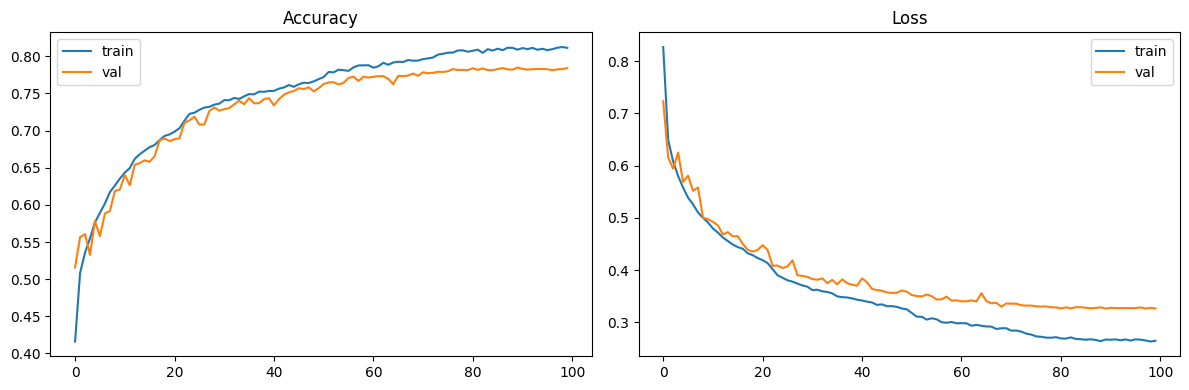

518/518 [==============================] - 10s 18ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.69      0.75      4144
           1       0.62      0.79      0.70      4143
           2       0.89      0.91      0.90      4144
           3       0.85      0.76      0.80      4144

    accuracy                           0.78     16575
   macro avg       0.80      0.78      0.79     16575
weighted avg       0.80      0.78      0.79     16575

Confusion Matrix:
[[2856 1139   42  107]
 [ 467 3270  169  237]
 [  37  159 3756  192]
 [  78  664  273 3129]]

🧠 Cohen Kappa Score: 0.7133


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpgrhzypwr\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpgrhzypwr\assets



⏱️ Total training time: 284.48 minutes


In [7]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_FS = 256
TARGET_FS = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_FS / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 4

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val - min_val == 0:
        return signal * 0
    return (signal - min_val) / (max_val - min_val)

def extract_dwt_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        features = []
        for c in coeffs:
            features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
        return np.array(features)
    except Exception as e:
        print(f"Error in DWT feature extraction: {e}")
        return np.zeros(25)  # 5 features * 5 coefficients (4 levels + approximation)

def map_to_4_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> Light Sleep
        2: 1,  # N2 -> Light Sleep
        3: 2,  # N3 -> Deep Sleep
        4: 3   # REM
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_FS, target_fs=TARGET_FS,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        dwt_features = np.array([extract_dwt_features(epoch) for epoch in epochs])
        return epochs, dwt_features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 25)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\apnea"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_dwt_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        epochs, dwt_features, mask = preprocess_ppg_signal(raw_signal)
        sleep_labels = map_to_4_classes(sleep_labels)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_dwt_list.append(dwt_features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_dwt_all = np.vstack(X_dwt_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, DWT features per epoch: {X_dwt_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("dwt_features.npy", X_dwt_all)
    np.save("sleep_labels_4class.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_dwt_all = X_dwt_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_dwt = []
augmented_labels = []
minority_classes = np.where(np.bincount(y_all.astype(int), minlength=NUM_CLASSES) < np.median(np.bincount(y_all.astype(int), minlength=NUM_CLASSES)))[0]

for ppg, dwt, label in zip(X_all, X_dwt_all, y_all):
    augmented_ppg.append(ppg)
    augmented_dwt.append(dwt)
    augmented_labels.append(label)
    if label in minority_classes:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_dwt = jitter(dwt, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(dwt)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_dwt = scaling(dwt, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_dwt_aug = np.array(augmented_dwt)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_dwt = StandardScaler()
    X_dwt_scaled = scaler_dwt.fit_transform(X_dwt_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_dwt_scaled)) or np.any(np.isinf(X_dwt_scaled)):
    raise ValueError("NaN or infinite values in X_dwt_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_dwt_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_dwt_scaled={X_dwt_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_dwt_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and DWT
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_dwt = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# --- Class weights ---
try:
    class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
except Exception as e:
    print(f"Error computing class weights: {e}")
    exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_dwt, X_test_dwt, y_train, y_test = train_test_split(
        X_res_ppg, X_res_dwt, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
X_train_ppg = X_train_ppg[..., np.newaxis]
X_test_ppg = X_test_ppg[..., np.newaxis]

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Dynamic focal loss alpha ---
class_freq = np.bincount(y_res.astype(int), minlength=NUM_CLASSES)
alpha = 1.0 / (class_freq + 1e-10)  # Inverse frequency
alpha = alpha / np.sum(alpha) * NUM_CLASSES  # Normalize to sum to num_classes
print(f"\nDynamic Focal Loss Alpha: {alpha.tolist()}")

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=alpha):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, dwt_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation="relu", kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation="sigmoid", kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    dwt_input = Input(shape=dwt_shape, name='dwt_input')
    d = GaussianNoise(0.02)(dwt_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    dwt_out = d
    combined = Concatenate()([ppg_out, dwt_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, dwt_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_dwt.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_dwt_4class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_dwt], y_train_cat,
                        validation_data=([X_test_ppg, X_test_dwt], y_test_cat),
                        epochs=100, batch_size=32, class_weight=class_weight_dict,
                        callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_dwt])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_dwt_rvfl_light_model_4class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_dwt_rvfl_light_model_4class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [8]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.7850


In [9]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.7870846536761357
Weighted F1 Score: 0.7870900524486049
Macro Precision: 0.7988290735526467
Macro Recall: 0.7849776353238518


In [10]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.8114, Val = 0.7841
📉 Final Loss: Train = 0.2645, Val = 0.3265


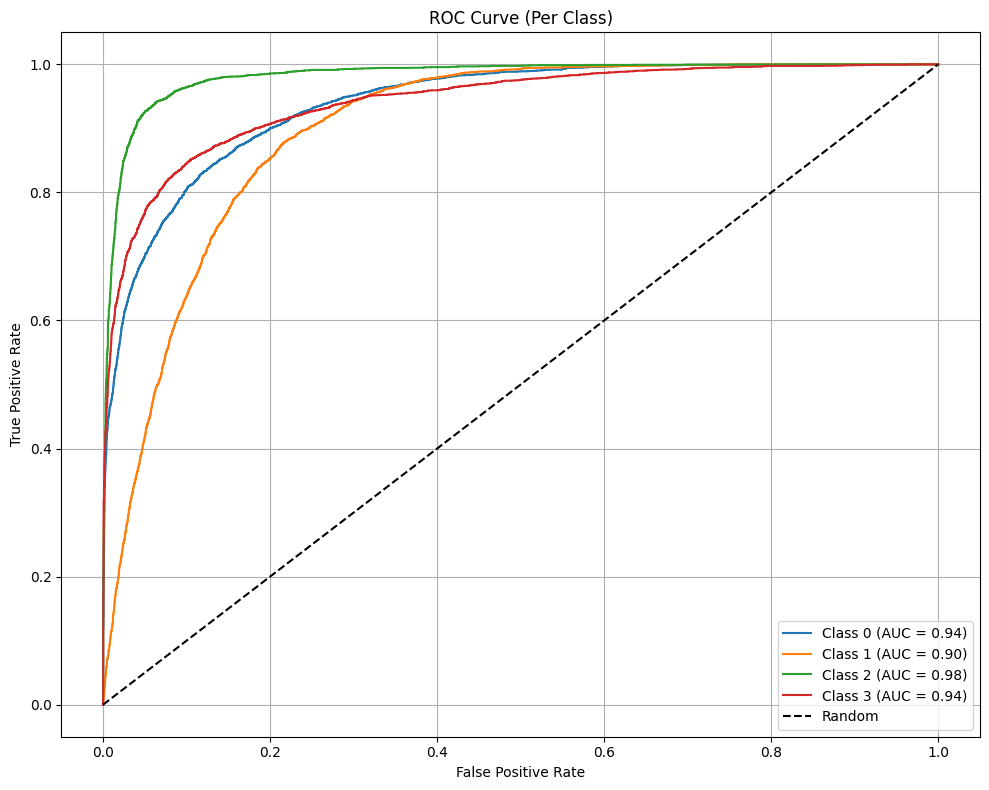

In [12]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 4
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 45746

Class Distribution Before Augmentation:
Class 0: 18163 samples (39.70%)
Class 1: 22832 samples (49.91%)
Class 2: 4751 samples (10.39%)

Class Distribution After Augmentation:
Class 0: 29022 samples (37.42%)
Class 1: 36609 samples (47.21%)
Class 2: 11921 samples (15.37%)

Class Distribution After SMOTE:
Class 0: 36609 samples (33.33%)
Class 1: 36609 samples (33.33%)
Class 2: 36609 samples (33.33%)

Fixed Focal Loss Alpha: [0.463, 0.437, 2.1]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                         

 max_pooling1d_1 (MaxPooling1D)  (None, 256, 32)     0           ['spatial_dropout1d_1[0][0]']    
                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
          

                                                                                                  
 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
          

2746/2746 [==============================] - 221s 80ms/step - loss: 0.1933 - accuracy: 0.7389 - val_loss: 0.2299 - val_accuracy: 0.7053 - lr: 2.5000e-05
Epoch 33/100
2746/2746 [==============================] - 219s 80ms/step - loss: 0.1919 - accuracy: 0.7414 - val_loss: 0.2343 - val_accuracy: 0.6989 - lr: 2.5000e-05
Epoch 34/100
2746/2746 [==============================] - 218s 79ms/step - loss: 0.1916 - accuracy: 0.7411 - val_loss: 0.2245 - val_accuracy: 0.6999 - lr: 2.5000e-05
Epoch 35/100
2746/2746 [==============================] - 221s 80ms/step - loss: 0.1889 - accuracy: 0.7424 - val_loss: 0.2319 - val_accuracy: 0.7032 - lr: 2.5000e-05
Epoch 36/100
2746/2746 [==============================] - 220s 80ms/step - loss: 0.1882 - accuracy: 0.7466 - val_loss: 0.2241 - val_accuracy: 0.6993 - lr: 2.5000e-05
Epoch 37/100
2746/2746 [==============================] - 222s 81ms/step - loss: 0.1877 - accuracy: 0.7451 - val_loss: 0.2307 - val_accuracy: 0.7021 - lr: 2.5000e-05
Epoch 38/100
2746

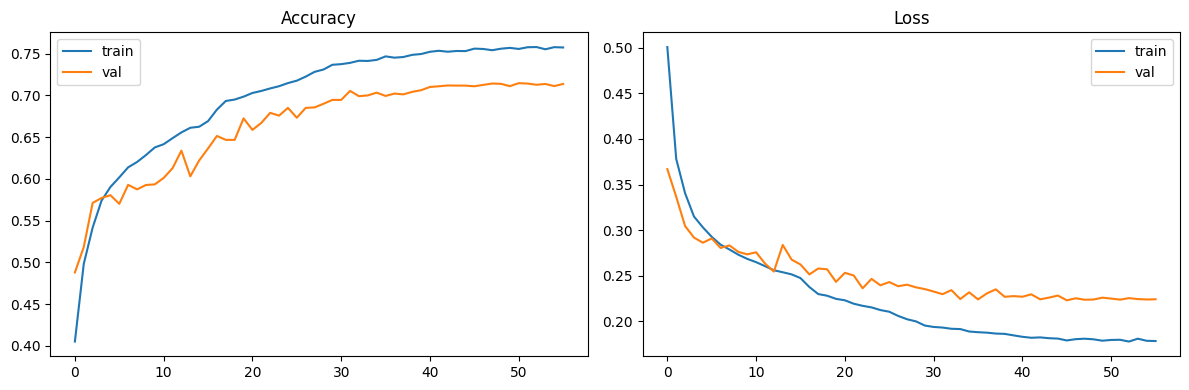

687/687 [==============================] - 12s 17ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.68      0.75      7322
           1       0.72      0.50      0.59      7322
           2       0.64      0.95      0.77      7322

    accuracy                           0.71     21966
   macro avg       0.73      0.71      0.70     21966
weighted avg       0.73      0.71      0.70     21966

Confusion Matrix:
[[4944 1156 1222]
 [ 954 3689 2679]
 [  48  293 6981]]

🧠 Cohen Kappa Score: 0.5662


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp7_jla38q\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp7_jla38q\assets



⏱️ Total training time: 204.13 minutes


In [3]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_SF = 256
TARGET_SF = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_SF / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 3

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def map_to_3_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> NREM
        2: 1,  # N2 -> NREM
        3: 1,  # N3 -> NREM
        4: 2   # REM
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_SF, target_fs=TARGET_SF,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\apnea"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        sleep_labels = map_to_3_classes(sleep_labels)
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels_3class.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 1]  # Wake, NREM

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# --- Class weights ---
try:
    class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
except Exception as e:
    print(f"Error computing class weights: {e}")
    exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Fixed focal loss alpha ---
alpha = [0.463, 0.437, 2.100]
print(f"\nFixed Focal Loss Alpha: {alpha}")

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=alpha):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_3class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                        validation_data=([X_test_ppg, X_test_features], y_test_cat),
                        epochs=100, batch_size=32, class_weight=class_weight_dict,
                        callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_3class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_3class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [4]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.7108


In [5]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.7014536187731103
Weighted F1 Score: 0.7014536187731102
Macro Precision: 0.7303283682224522
Macro Recall: 0.7108258217244833


In [6]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.7573, Val = 0.7136
📉 Final Loss: Train = 0.1785, Val = 0.2243


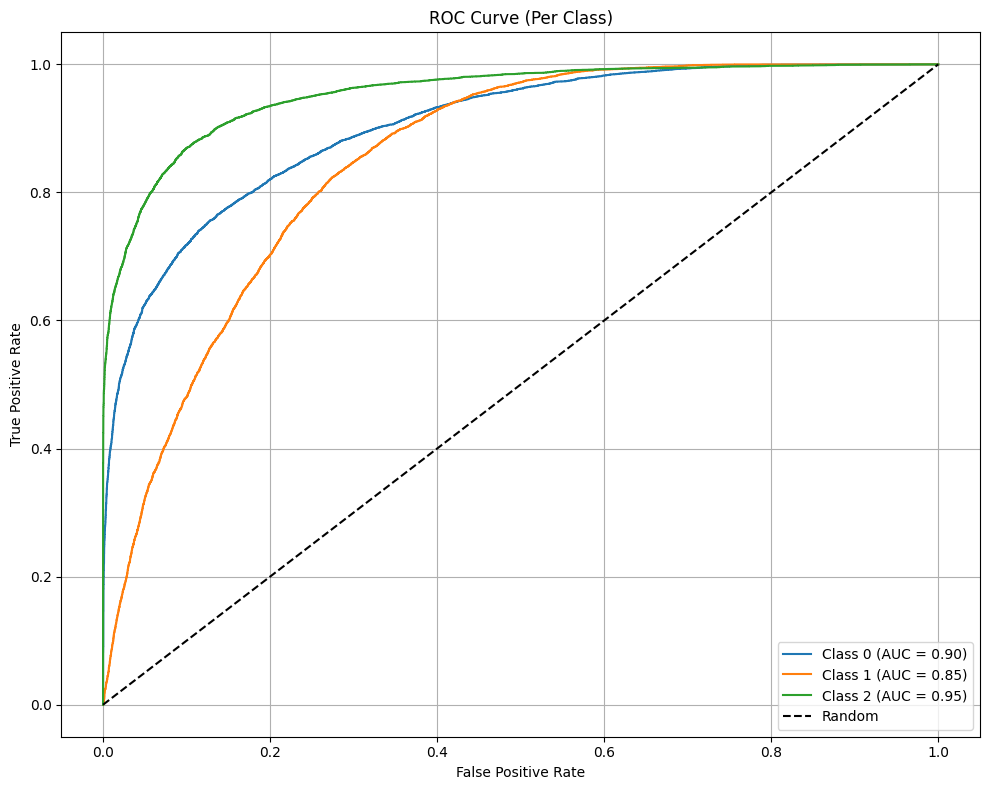

In [7]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 3
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 45746

Class Distribution Before Augmentation:
Class 0: 18163 samples (39.70%)
Class 1: 22832 samples (49.91%)
Class 2: 4751 samples (10.39%)

Class Distribution After Augmentation:
Class 0: 29022 samples (37.42%)
Class 1: 36609 samples (47.21%)
Class 2: 11921 samples (15.37%)

Class Distribution After SMOTE:
Class 0: 36609 samples (33.33%)
Class 1: 36609 samples (33.33%)
Class 2: 36609 samples (33.33%)

Fixed Focal Loss Alpha: [0.154, 0.145, 0.701]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                       

 max_pooling1d_1 (MaxPooling1D)  (None, 256, 32)     0           ['spatial_dropout1d_1[0][0]']    
                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
          

                                                                                                  
 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
          

2746/2746 [==============================] - 213s 77ms/step - loss: 0.0670 - accuracy: 0.7361 - val_loss: 0.0752 - val_accuracy: 0.7002 - lr: 5.0000e-05
Epoch 33/100
2746/2746 [==============================] - 214s 78ms/step - loss: 0.0668 - accuracy: 0.7372 - val_loss: 0.0764 - val_accuracy: 0.6985 - lr: 5.0000e-05
Epoch 34/100
2746/2746 [==============================] - 216s 79ms/step - loss: 0.0658 - accuracy: 0.7390 - val_loss: 0.0750 - val_accuracy: 0.6940 - lr: 5.0000e-05
Epoch 35/100
2746/2746 [==============================] - 216s 79ms/step - loss: 0.0655 - accuracy: 0.7422 - val_loss: 0.0755 - val_accuracy: 0.7029 - lr: 5.0000e-05
Epoch 36/100
2746/2746 [==============================] - 215s 78ms/step - loss: 0.0655 - accuracy: 0.7420 - val_loss: 0.0756 - val_accuracy: 0.7018 - lr: 5.0000e-05
Epoch 37/100
2746/2746 [==============================] - 216s 79ms/step - loss: 0.0652 - accuracy: 0.7415 - val_loss: 0.0748 - val_accuracy: 0.7003 - lr: 5.0000e-05
Epoch 38/100
2746

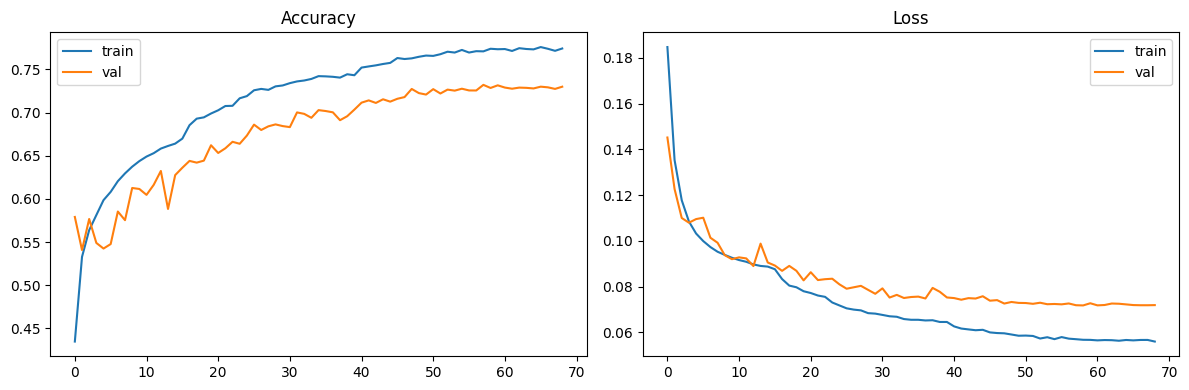

687/687 [==============================] - 11s 15ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.66      0.74      7322
           1       0.73      0.56      0.64      7322
           2       0.67      0.96      0.79      7322

    accuracy                           0.73     21966
   macro avg       0.75      0.73      0.72     21966
weighted avg       0.75      0.73      0.72     21966

Confusion Matrix:
[[4860 1296 1166]
 [ 827 4128 2367]
 [  62  245 7015]]

🧠 Cohen Kappa Score: 0.5928


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp9jynmq99\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp9jynmq99\assets



⏱️ Total training time: 246.92 minutes


In [8]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_SF = 256
TARGET_SF = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_SF / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 3

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def map_to_3_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> NREM
        2: 1,  # N2 -> NREM
        3: 1,  # N3 -> NREM
        4: 2   # REM
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_SF, target_fs=TARGET_SF,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\apnea"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        sleep_labels = map_to_3_classes(sleep_labels)
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels_3class.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 1]  # Wake, NREM

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# --- Class weights ---
try:
    class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
except Exception as e:
    print(f"Error computing class weights: {e}")
    exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Fixed focal loss alpha ---
alpha = [0.154, 0.145, 0.701]
print(f"\nFixed Focal Loss Alpha: {alpha}")

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=alpha):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_3class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                        validation_data=([X_test_ppg, X_test_features], y_test_cat),
                        epochs=100, batch_size=32, class_weight=class_weight_dict,
                        callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_3class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_3class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [9]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.7285


In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.7214208508118679
Weighted F1 Score: 0.7214208508118679
Macro Precision: 0.7461967170495175
Macro Recall: 0.7285350086497315


In [11]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.7743, Val = 0.7300
📉 Final Loss: Train = 0.0560, Val = 0.0719


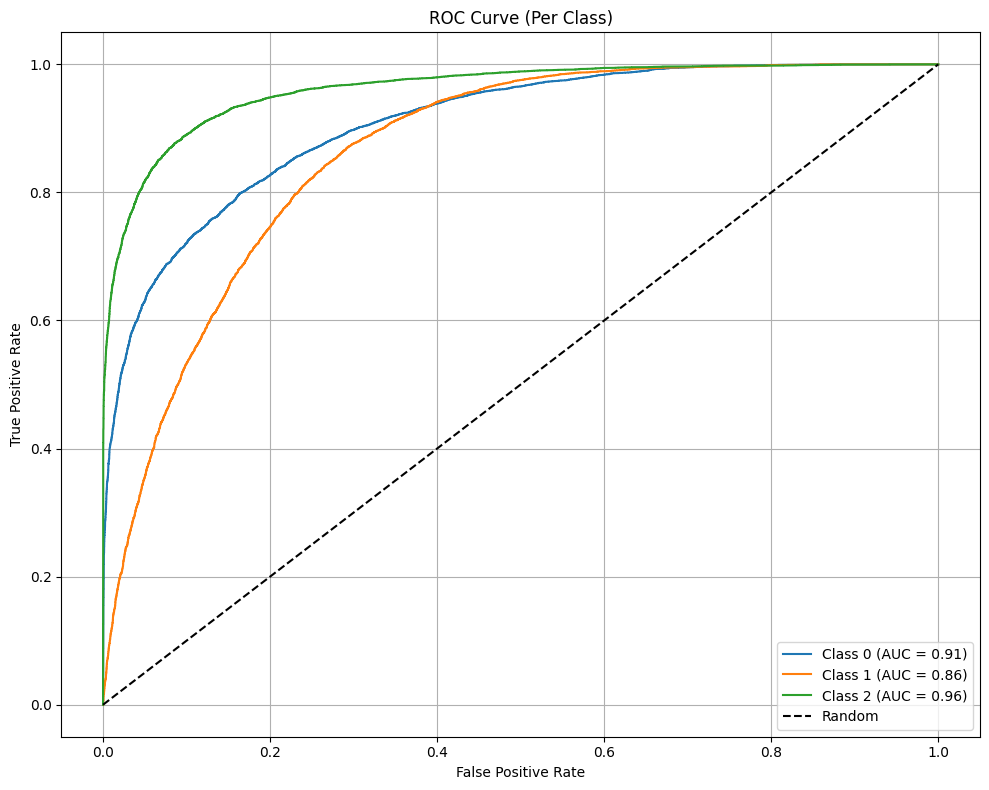

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 3
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 45746

Class Distribution Before Augmentation:
Class 0: 18163 samples (39.70%)
Class 1: 22832 samples (49.91%)
Class 2: 4751 samples (10.39%)

Class Distribution After Augmentation:
Class 0: 29022 samples (37.42%)
Class 1: 36609 samples (47.21%)
Class 2: 11921 samples (15.37%)

Class Distribution After SMOTE:
Class 0: 29022 samples (34.75%)
Class 1: 36609 samples (43.84%)
Class 2: 17881 samples (21.41%)

Fixed Focal Loss Alpha: [0.154, 0.145, 0.701]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                       

 max_pooling1d_1 (MaxPooling1D)  (None, 256, 32)     0           ['spatial_dropout1d_1[0][0]']    
                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
          

                                                                                                  
 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
          

2088/2088 [==============================] - 178s 85ms/step - loss: 0.0721 - accuracy: 0.6741 - val_loss: 0.0827 - val_accuracy: 0.6581 - lr: 2.5000e-05
Epoch 33/100
2088/2088 [==============================] - 180s 86ms/step - loss: 0.0716 - accuracy: 0.6730 - val_loss: 0.0828 - val_accuracy: 0.6343 - lr: 2.5000e-05
Epoch 34/100
2088/2088 [==============================] - 178s 85ms/step - loss: 0.0716 - accuracy: 0.6737 - val_loss: 0.0813 - val_accuracy: 0.6492 - lr: 2.5000e-05
Epoch 35/100
2088/2088 [==============================] - 178s 85ms/step - loss: 0.0709 - accuracy: 0.6774 - val_loss: 0.0830 - val_accuracy: 0.6566 - lr: 2.5000e-05
Epoch 36/100
2088/2088 [==============================] - 178s 85ms/step - loss: 0.0707 - accuracy: 0.6788 - val_loss: 0.0822 - val_accuracy: 0.6600 - lr: 2.5000e-05
Epoch 37/100
2088/2088 [==============================] - 182s 87ms/step - loss: 0.0705 - accuracy: 0.6764 - val_loss: 0.0828 - val_accuracy: 0.6480 - lr: 2.5000e-05
Epoch 38/100
2088

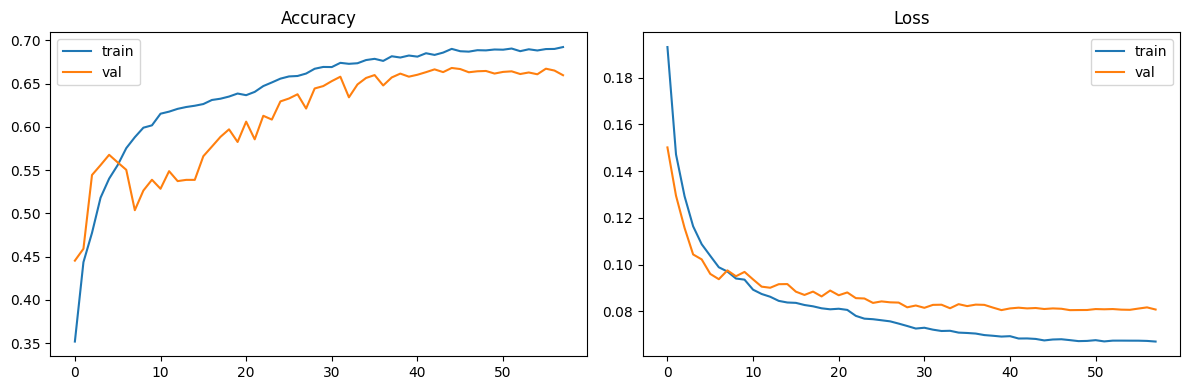

522/522 [==============================] - 12s 22ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.65      0.72      5805
           1       0.73      0.56      0.64      7322
           2       0.50      0.89      0.64      3576

    accuracy                           0.66     16703
   macro avg       0.68      0.70      0.67     16703
weighted avg       0.71      0.66      0.67     16703

Confusion Matrix:
[[3776 1256  773]
 [ 824 4131 2367]
 [  85  301 3190]]

🧠 Cohen Kappa Score: 0.5006


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmps82gn5yy\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmps82gn5yy\assets



⏱️ Total training time: 176.98 minutes


In [13]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_SF = 256
TARGET_SF = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_SF / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 3

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def map_to_3_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> NREM
        2: 1,  # N2 -> NREM
        3: 1,  # N3 -> NREM
        4: 2   # REM
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_SF, target_fs=TARGET_SF,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\apnea"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        sleep_labels = map_to_3_classes(sleep_labels)
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels_3class.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 1]  # Wake, NREM

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1,
                      sampling_strategy={0: class_counts[0], 1: class_counts[1], 2: int(class_counts[2] * 1.5)})
    else:
        smote = SMOTE(random_state=42, sampling_strategy={0: class_counts[0], 1: class_counts[1], 2: int(class_counts[2] * 1.5)})
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)
    
# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# # --- Class weights ---
# try:
#     class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
#     class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
# except Exception as e:
#     print(f"Error computing class weights: {e}")
#     exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Fixed focal loss alpha ---
alpha = [0.154, 0.145, 0.701]
print(f"\nFixed Focal Loss Alpha: {alpha}")

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=alpha):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_3class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                    validation_data=([X_test_ppg, X_test_features], y_test_cat),
                    epochs=100, batch_size=32,  # Remove class_weight=class_weight_dict
                    callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_3class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_3class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 45746

Class Distribution Before Augmentation:
Class 0: 18163 samples (39.70%)
Class 1: 27583 samples (60.30%)

Class Distribution After Augmentation:
Class 0: 29075 samples (39.67%)
Class 1: 44214 samples (60.33%)

Class Distribution After SMOTE:
Class 0: 44214 samples (50.00%)
Class 1: 44214 samples (50.00%)

Fixed Focal Loss Alpha: [0.562, 0.438]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 1024, 1)     0    

                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 tf.math.s

 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 concatena

Epoch 33/100
2211/2211 [==============================] - 185s 84ms/step - loss: 0.0819 - accuracy: 0.7969 - val_loss: 0.0877 - val_accuracy: 0.7905 - lr: 2.5000e-05
Epoch 34/100
2211/2211 [==============================] - 189s 86ms/step - loss: 0.0814 - accuracy: 0.7982 - val_loss: 0.0880 - val_accuracy: 0.7905 - lr: 2.5000e-05
Epoch 35/100
2211/2211 [==============================] - 191s 86ms/step - loss: 0.0806 - accuracy: 0.8008 - val_loss: 0.0871 - val_accuracy: 0.7944 - lr: 1.2500e-05
Epoch 36/100
2211/2211 [==============================] - 190s 86ms/step - loss: 0.0805 - accuracy: 0.8005 - val_loss: 0.0885 - val_accuracy: 0.7922 - lr: 1.2500e-05
Epoch 37/100
2211/2211 [==============================] - 191s 86ms/step - loss: 0.0801 - accuracy: 0.8022 - val_loss: 0.0880 - val_accuracy: 0.7938 - lr: 1.2500e-05
Epoch 38/100
2211/2211 [==============================] - 190s 86ms/step - loss: 0.0798 - accuracy: 0.8019 - val_loss: 0.0887 - val_accuracy: 0.7905 - lr: 6.2500e-06
Epoc

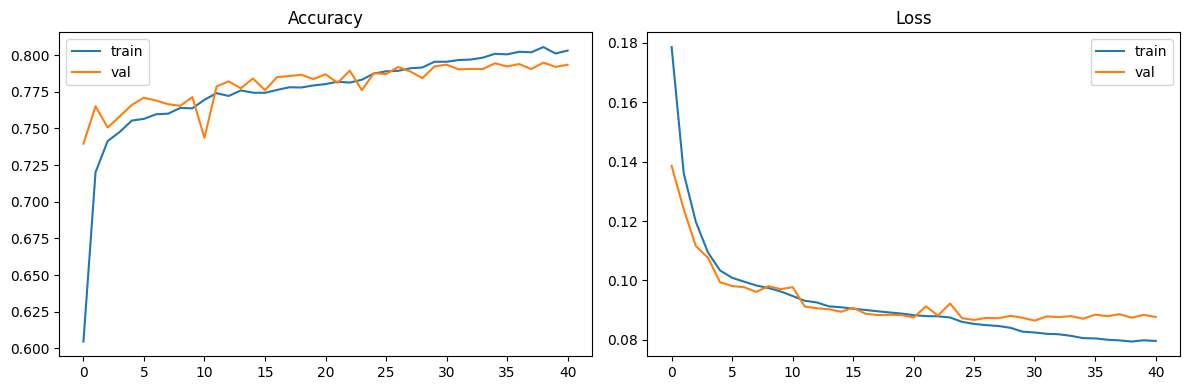

553/553 [==============================] - 11s 18ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      8843
           1       0.76      0.86      0.81      8843

    accuracy                           0.79     17686
   macro avg       0.80      0.79      0.79     17686
weighted avg       0.80      0.79      0.79     17686

Confusion Matrix:
[[6435 2408]
 [1245 7598]]

🧠 Cohen Kappa Score: 0.5869


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp8aw0_3b_\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp8aw0_3b_\assets



⏱️ Total training time: 129.33 minutes


In [14]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_SF = 256
TARGET_SF = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_SF / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 2

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def map_to_3_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> NREM
        2: 1,  # N2 -> NREM
        3: 1,  # N3 -> NREM
        4: 1   # REM
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_SF, target_fs=TARGET_SF,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\apnea"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        sleep_labels = map_to_3_classes(sleep_labels)
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels_3class.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 1]  # Wake, NREM

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# --- Class weights ---
try:
    class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
except Exception as e:
    print(f"Error computing class weights: {e}")
    exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Fixed focal loss alpha ---
alpha = alpha = [0.562, 0.438]
print(f"\nFixed Focal Loss Alpha: {alpha}")

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=alpha):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_3class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                        validation_data=([X_test_ppg, X_test_features], y_test_cat),
                        epochs=100, batch_size=32, class_weight=class_weight_dict,
                        callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_3class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_3class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [15]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.7935


In [16]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.7925554279801807
Weighted F1 Score: 0.7925554279801806
Macro Precision: 0.7986175091819908
Macro Recall: 0.7934524482641638


In [17]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.8030, Val = 0.7933
📉 Final Loss: Train = 0.0797, Val = 0.0877


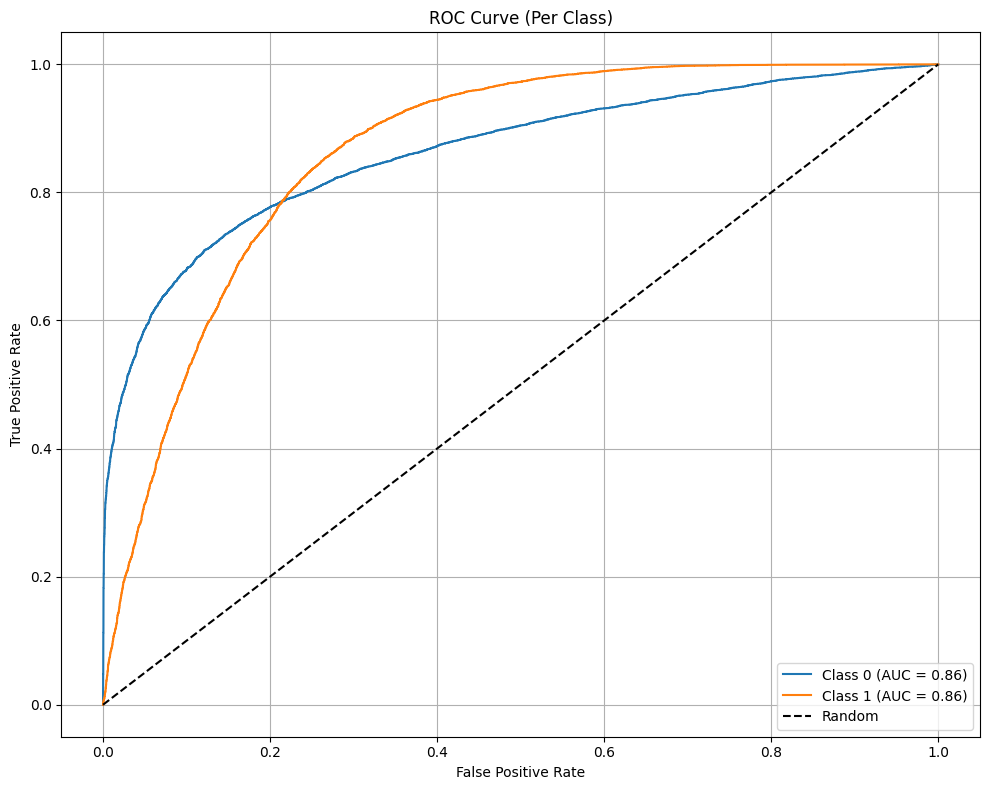

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 2
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

